In [1]:
%pylab inline
from scipy.io import loadmat
from sklearn.metrics import f1_score
from sklearn.covariance import EllipticEnvelope
from numpy.linalg import det, inv, pinv

Populating the interactive namespace from numpy and matplotlib


In [2]:
data1 = loadmat('ex8data1.mat')
X = data1['X'].astype(float)
Xval = data1['Xval'].astype(float)
yval = data1['yval'].astype(float)

Text(0,0.5,'Throughout (mb/s)')

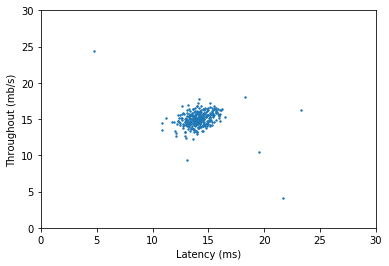

In [3]:
plt.scatter(*X.T, s=2);
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughout (mb/s)")

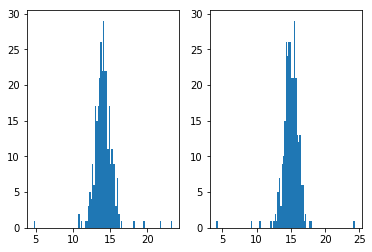

In [4]:
def plot_histograms(X):
    f, ax = plt.subplots(1,2)
    ax[0].hist(X[:,0], bins=100);
    ax[1].hist(X[:,1], bins=100);
    
plot_histograms(X)

In [5]:
#X_mean = np.mean(X, axis=0)
#X_var = np.var(X, axis=0)
#X_cov = np.cov(X, rowvar=False, bias=True)

def gaussian(X, X_mean, X_var):
    distrib = np.exp(-(X-X_mean)**2 / (2*X_var)) / np.sqrt(2*np.pi*X_var)
    return np.prod(distrib, axis=-1)

def multivariate_gaussian(X, X_mean, X_cov):
    X_norm = X - X_mean
    num = exp(-0.5 * diag(X_norm @ inv(X_cov) @ X_norm.T))
    den = sqrt((2*pi)**X.shape[1] * det(X_cov))
    return num / den

In [6]:
def my_f1_score(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_pred == y_true), axis=0)
    precision = tp / y_pred.sum(0)
    recall = tp / y_true.sum(0)
    return (2 * precision * recall / (precision + recall))[0]

### Normal Distribution Probality Density

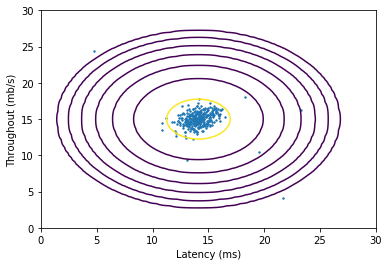

In [7]:
def plot_univariate_gaussian(X):
    X_mean = np.mean(X, axis=0)
    X_var = np.var(X, axis=0)

    xs, ys = meshgrid(np.linspace(0,30,100), np.linspace(0,30,100))
    zs = gaussian(np.dstack([xs,ys]), X_mean, X_var)

    plt.scatter(*X.T, s=2);
    plt.contour(xs,ys,zs, levels=np.logspace(-20,1, 8))
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughout (mb/s)")
    
plot_univariate_gaussian(X)

min: 4.5132509303098265e-36, max: 0.08990852779269493


(0.00010001000100010001, 0.8750000000000001)

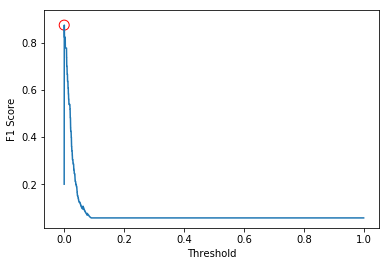

In [8]:
def select_univariate_thresholds(X, Xval, yval, plot=False):
    X_mean = np.mean(X, axis=0)
    X_var = np.var(X, axis=0)
    X_cov = np.cov(X, rowvar=False, bias=True)
    
    probs = gaussian(Xval, X_mean, X_var)
    print(f'min: {probs.min(0)}, max: {probs.max(0)}')
    thresholds = np.linspace(10e-36,10e-1,10000)
    scores = np.zeros_like(thresholds)
    for i,eps in enumerate(thresholds):
        p = (probs < eps).astype(int).reshape(-1,1)
        scores[i] = my_f1_score(p, yval)
    max_idx = np.argmax(scores, axis=0)
    max_threshold, max_score = thresholds[max_idx], scores[max_idx]
    if plot:
        plt.plot(thresholds, scores);
        plt.scatter(max_threshold, max_score,
                    edgecolors='r', c='', s=100)
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
    return max_threshold, max_score
    
select_univariate_thresholds(X, Xval, yval, plot=True)

min: 4.5132509303098265e-36, max: 0.08990852779269493


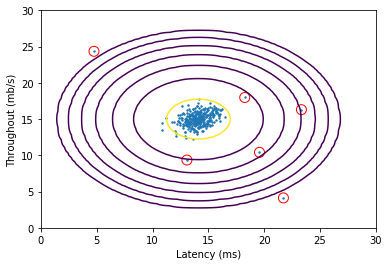

In [9]:
def plot_univariate_outliers(X, Xval, yval):
    X_mean = np.mean(X, axis=0)
    X_var = np.var(X, axis=0)
    X_cov = np.cov(X, rowvar=False, bias=True)
    
    eps, _ = select_univariate_thresholds(X, Xval, yval)
    anomalies = (gaussian(X, X_mean, X_var) < eps).astype(int).reshape(-1,1)
    
    xs, ys = meshgrid(np.linspace(0,30,100), np.linspace(0,30,100))
    zs = gaussian(np.dstack([xs,ys]), X_mean, X_var)

    plt.scatter(*X.T, s=2);
    plt.contour(xs,ys,zs, levels=np.logspace(-20,1, 8))
    plt.scatter(*X[anomalies[:,0] == 1].T, edgecolors='r', c='', s=100)
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughout (mb/s)")
    
plot_univariate_outliers(X, Xval, yval)

### Normal Distribution Multivariate Probability Density

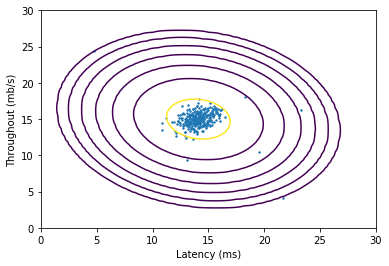

In [10]:
def plot_multivariate_gaussian(X):
    X_mean = np.mean(X, axis=0)
    X_cov = np.cov(X, rowvar=False, bias=True)

    xs, ys = meshgrid(np.linspace(0,30,100), np.linspace(0,30,100))
    zs = multivariate_gaussian(np.dstack([xs,ys]).reshape(-1,2), X_mean, X_cov).reshape(100,100)

    plt.scatter(*X.T, s=2);
    plt.contour(xs,ys,zs, levels=np.logspace(-20,1, 8))
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughout (mb/s)")
    
plot_multivariate_gaussian(X)

min: 6.911308421300042e-41, max: 0.09065769728392736


(0.00010001000100010001, 0.8750000000000001)

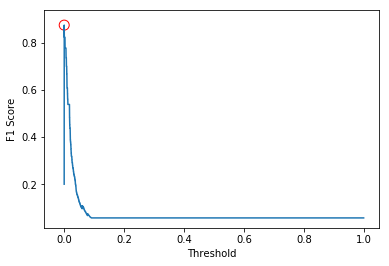

In [11]:
def select_multivariate_thresholds(X, Xval, yval, plot=False):
    X_mean = np.mean(X, axis=0)
    X_var = np.var(X, axis=0)
    X_cov = np.cov(X, rowvar=False, bias=True)
    
    probs = multivariate_gaussian(Xval, X_mean, X_cov)
    print(f'min: {probs.min(0)}, max: {probs.max(0)}')
    thresholds = np.linspace(10e-41,10e-1,10000)
    scores = np.zeros_like(thresholds)
    for i,eps in enumerate(thresholds):
        p = (probs < eps).astype(int).reshape(-1,1)
        scores[i] = my_f1_score(p, yval)
    max_idx = np.argmax(scores, axis=0)
    max_threshold, max_score = thresholds[max_idx], scores[max_idx]
    if plot:
        plt.plot(thresholds, scores);
        plt.scatter(max_threshold, max_score,
                    edgecolors='r', c='', s=100)
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
    return max_threshold, max_score
    
select_multivariate_thresholds(X, Xval, yval, plot=True)

min: 6.911308421300042e-41, max: 0.09065769728392736


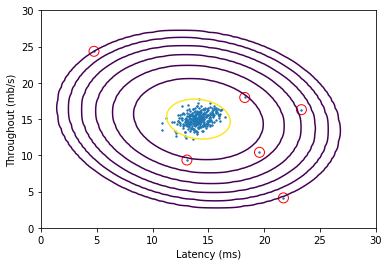

In [12]:
def plot_multivariate_outliers(X, Xval, yval):
    X_mean = np.mean(X, axis=0)
    X_var = np.var(X, axis=0)
    X_cov = np.cov(X, rowvar=False, bias=True)
    
    eps, _ = select_multivariate_thresholds(X, Xval, yval)
    anomalies = (multivariate_gaussian(X, X_mean, X_cov) < eps).reshape(-1,1)
    
    xs, ys = meshgrid(np.linspace(0,30,100), np.linspace(0,30,100))
    zs = multivariate_gaussian(np.dstack([xs,ys]).reshape(-1,2), X_mean, X_cov).reshape(100,100)

    plt.scatter(*X.T, s=2);
    plt.contour(xs,ys,zs, levels=np.logspace(-20,1, 8))
    plt.scatter(*X[anomalies[:,0] == 1].T, edgecolors='r', c='', s=100)
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughout (mb/s)")
    
plot_multivariate_outliers(X, Xval, yval)

In [13]:
data2 = loadmat("ex8data2.mat")
X2 = data2['X'].astype(float)
X2val = data2['Xval'].astype(float)
y2val = data2['yval'].astype(float)

min: 2.2251550788971615e-27, max: 1.7538488690229487e-15
1.0001000200000001e-18 0.6153846153846154


96

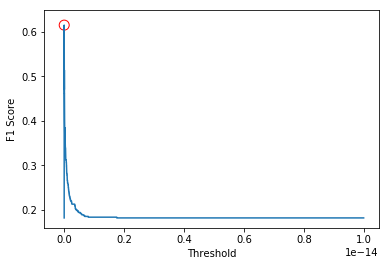

In [14]:
def select_multivariate_thresholds2(X, Xval, yval, plot=False):
    X_mean = np.mean(X, axis=0)
    X_var = np.var(X, axis=0)
    X_cov = np.cov(X, rowvar=False, bias=True)
    
    probs = multivariate_gaussian(Xval, X_mean, X_cov)
    print(f'min: {probs.min(0)}, max: {probs.max(0)}')
    thresholds = np.linspace(10e-27, 10e-15, 10000)
    scores = np.zeros_like(thresholds)
    for i,eps in enumerate(thresholds):
        p = (probs < eps).astype(int).reshape(-1,1)
        scores[i] = my_f1_score(p, yval)
    max_idx = np.argmax(scores, axis=0)
    max_threshold, max_score = thresholds[max_idx], scores[max_idx]
    if plot:
        plt.plot(thresholds, scores);
        plt.scatter(max_threshold, max_score,
                    edgecolors='r', c='', s=100)
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
    return max_threshold, max_score
    
threshold, score = select_multivariate_thresholds2(X2, X2val, y2val, plot=True)
print(threshold, score)
X2_mean = np.mean(X2, axis=0)
X2_var = np.var(X2, axis=0)
X2_cov = np.cov(X2, rowvar=False, bias=True)
np.sum(multivariate_gaussian(X2, X2_mean, X2_cov) < threshold)